# Fandango Movie Ratings

FiveThirtyEight published an article regarding online movie rating aggregations, and how, in particular, Fandango inflate movie scores. It can be read [here](https://fivethirtyeight.com/features/fandango-movies-ratings/).

We will read the dataset and perform statistical analysis along the way.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
movies = pd.read_csv("data-sets/fandango_score_comparison.csv")
movies.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


The reviews scores are different between sites: Fandango has a 0-5-star rating system that includes half stars; Metacritic and Rotton Tomatoes review scores on a 0-100-point scale and IMDB  uses a 10-point scale. The scores are normalized to compare it to Fandango's rating system.

# Statistical Exploration

Now that we have loaded the dataset, we can do some statistical analysis on the "ratings" columns.

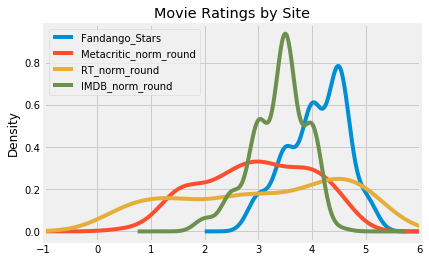

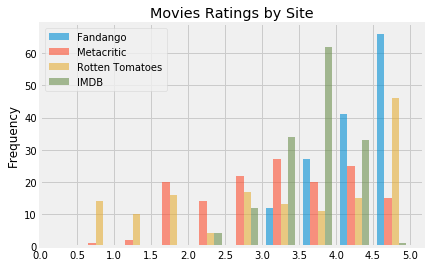

In [31]:
fstars = movies["Fandango_Stars"]
mcritic = movies["Metacritic_norm_round"]
rt = movies["RT_norm_round"]
imdb = movies["IMDB_norm_round"]

#kurtosis
movie_cols = ["Fandango_Stars", "Metacritic_norm_round", "RT_norm_round", "IMDB_norm_round"]
for cols in movie_cols:
    movies[cols].kurtosis()
    movies[cols].plot(kind="density", 
                      title="Movie Ratings by Site",
                      xlim=(-1,6),
                      legend=True)

    
#histogram
kwargs = dict(histtype='bar', width=0.1, alpha=0.6, bins=9)
data = np.column_stack([fstars, mcritic, rt, imdb])
fig = plt.figure(figsize=(6.1,4.1))

plt.hist(data, label=["Fandango", "Metacritic", "Rotten Tomatoes", "IMDB"], **kwargs)
plt.xticks(np.arange(0,5.1,0.5))
plt.ylabel("Frequency")
plt.title("Movies Ratings by Site")
plt.legend(loc="upper left")

The histogram and density plot display Rotton Tomatoes reviews as a slight uniform distribution; IMDB reviews have a leptokurtic distribution, and Metacritic reviews have a platykurtic distribution. Take note of Fandango reviews: the lowest value is 3.0, and it has a negative skew. We will reach a further understanding by looking at the descriptive statistics.

In [33]:
#Obtain the mean, median, and standard deviation

review_cols = ["Fandango_Stars", "Metacritic_norm_round", "RT_norm_round", "IMDB_norm_round"]
table = pd.DataFrame(columns=["Mean", "Standard Dev", "Median"])

for cols in review_cols:
    mean = np.mean(movies[cols])
    std = np.std(movies[cols])
    median = np.median(movies[cols])
    table.loc[len(table)] = [mean, std, median]

table = table.set_index(keys=[["Fandango", "Metacritic", "Rotten Tomatoes", "IMDB"]])
table = table.round(3)
table

,Mean,Standard Dev,Median
Fandango,4.089,0.539,4.0
Metacritic,2.973,0.988,3.0
Rotten Tomatoes,3.065,1.509,3.0
IMDB,3.380,0.501,3.5


It is probable that Fandango inflates the review scores. Fandango's mean and median is higher in comparison to the rest. Also, its mean is higher than the median indicating that several high ratings skew the mean upwards. Next, we will compare how Fandango's score conveys to Metacritic with a scatterplot. 

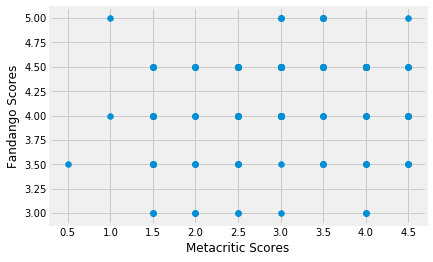

In [34]:
plt.scatter(movies["Metacritic_norm_round"], movies["Fandango_Stars"])
plt.ylabel("Fandango Scores")
plt.xlabel("Metacritic Scores")

The rectangular shape presented in the scatterplot is due to normalizing Metacritic review scores and how efficiently it matches Fandango's rating system. Here, we could expect the values on the y-axis to raise concerning the values along the x-axis. It suggests that several movies are scored low on Metacritic and high on Fandango. Let's explore this further by finding the difference between the columns using the absolute value. 

In [65]:
movies["fm_diff"] = np.abs(movies["Metacritic_norm_round"] - movies["Fandango_Stars"])
movies.sort_values(by="fm_diff", ascending=False, inplace=True)
movies[["FILM", "Fandango_Stars", "Metacritic_norm_round", "fm_diff"]].head()

,FILM,Fandango_Stars,Metacritic_norm_round,fm_diff
3,Do You Believe? (2015),5.0,1.0,4.0
85,Little Boy (2015),4.5,1.5,3.0
47,Annie (2014),4.5,1.5,3.0
19,Pixels (2015),4.5,1.5,3.0
134,The Longest Ride (2015),4.5,1.5,3.0


_Do You Believe?_ has a 4-star difference while the other movies have a 3-star difference. Let's determine if there is any correlation between these scores. 

In [50]:
r_value, p_value = pearsonr(movies["Fandango_Stars"], movies["Metacritic_norm_round"])
print("Correlation: {0}".format(r_value))
print("P-value:     {0}".format(p_value))

slope, intercept, r_value, p_value, std_err = linregress(movies["Metacritic_norm_round"], movies["Fandango_Stars"])
predict_3 = 3 * slope + intercept
print("\n")
print("The linear regression is y = {0}x + {1}".format(slope, intercept))
print("If we predict a movie score on Fandango given a 3.0 on Metacritic: {0}".format(np.round(predict_3)))

Correlation: 0.17844919073895918
P-value:     0.031161516228523815


The linear regression is y = 0.09731107797392827x + 3.799773918899419
If we predict a movie score on Fandango given a 3.0 on Metacritic: 4.0


The weak correlation between Fandango and Metacritic suggests that Fandango scores appear inflated and they are fundamentally different. The reason is unknown as to why Fandango inflates their scores overall. Next, we will graph the correlation on the scatterplot.

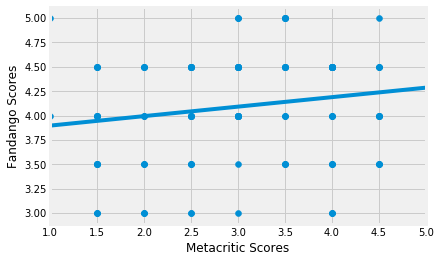

In [53]:
#Graph the Residuals
predict_1 = 1 * slope + intercept
predict_5 = 5 * slope + intercept
plt.scatter(movies["Metacritic_norm_round"], movies["Fandango_Stars"])
plt.plot([1.0,5.0], [predict_1, predict_5])
plt.xlim(1,5)
plt.tick_params(
    axis='both',
    which='both',
    left='off',
    bottom='off',
    right='off',
    top='off'
)
plt.ylabel("Fandango Scores")
plt.xlabel("Metacritic Scores")
plt.show()

As expected, poor correlation is not a good fit and predictor for movie reviews.

## Conclusion
We have looked at the dataset and use statistical analysis to compare movie ratings between Metacritic and Fandango. As such, based on the analysis, it is proportional that Fandango not only inflates their reviews but projects specific movies to a higher rating. 